In [1]:
'poop'


'poop'

In [2]:
import constants
constants.GRAVITATIONAL_ACCELERATION=0.0
from ParticleClass import Swarm
from collectorSimulationHelperFunctions import build_collector_lattice,CollectorSwarmAnalyzer
from phaseSpaceAnalysis_Functions import transfer_particles_to_new_swarm
from SwarmTracerClass import SwarmTracer
import numpy as np
import matplotlib.pyplot as plt
import time
ap=None
lattice=build_collector_lattice(interp_density_mult=3,ap=ap)
st=SwarmTracer(lattice)
%matplotlib inline
# lattice.show_lattice()

In [7]:
ap=lattice.el_list[1].ap
pr_max=lattice.speed_nominal*(1e2*ap/72)
print(ap)

0.04904430316234297


In [8]:
def rotate_swarm(swarm):
    for particle in swarm:
        particle.pi[0]*=-1
        particle.qi[0]+=5e-10
def make_point_source_swarm(num_particles):
    swarm=st.initalize_pseudorandom_swarm_in_phase_space(1e-9,pr_max,1e-9,num_particles,same_seed=True)
    rotate_swarm(swarm)
    return swarm
def make_simulated_swarm(num_particles):
    file='/Users/williamdebenham/Desktop/storageRing/storageRing/storageRingModel/massiveSwarms/300millionParticles_Theory.txt'
    particle_data=np.loadtxt(file)
    np.random.shuffle(particle_data)
    swarm_initial=Swarm()
    for data in particle_data[:num_particles]:
        x,y,z,px,py,pz=data
        swarm_initial.add_new_particle(np.array([x,y,z]),np.array([px,py,pz]))
    return swarm_initial

def make_small_source_swarm(num_particles):
    swarm=st.initalize_pseudorandom_swarm_in_phase_space(1e-3,pr_max,1e-9,num_particles,same_seed=True)
    rotate_swarm(swarm)
    return swarm

def make_square_source_swarm(num_particles):
    circle_factor=4/np.pi
    swarm_square=st.initalize_pseudorandom_swarm_in_phase_space(2e-3,pr_max,1e-9,num_particles*circle_factor,same_seed=True,circular=False)
    swarm_valid=Swarm()
    for particle in swarm_square:
        _,py,pz=particle.pi
        if np.sqrt(py**2+pz**2)< pr_max:
            swarm_valid.add(particle)
    rotate_swarm(swarm_valid)
    return swarm_valid
def make_swarm(num_particles_to_trace,source_type):
    if source_type=='point':
        swarm_initial=make_point_source_swarm(num_particles_to_trace)
    elif source_type=='circle':
        swarm_initial=make_small_source_swarm(num_particles_to_trace)
    elif source_type=='simulated':
        swarm_initial=make_simulated_swarm(num_particles_to_trace)
    elif source_type=='square':
        swarm_initial=make_square_source_swarm(num_particles_to_trace)
    else:
        raise NotImplementedError
    return swarm_initial


In [9]:
from ParticleClass import Swarm

def trace_swarm(num_particles_to_trace,source_type='point'):
    swarm_initial=make_swarm(num_particles_to_trace,source_type)
    work_size=300_000
    swarm_traced=Swarm()
    while len(swarm_initial)>0:
        swarm_to_trace=transfer_particles_to_new_swarm(swarm_initial,work_size)
        print(len(swarm_initial))
        swarm_traced_small=st.trace_swarm_through_lattice(swarm_to_trace,5e-6,1.0,parallel=True,use_fast_mode=True,accelerated=True)
        swarm_traced.particles.extend(swarm_traced_small.particles)
    return swarm_traced
t=time.time()
num_particles_approx=20_000_000
source_type='point'
swarm_traced=trace_swarm(num_particles_approx,source_type=source_type)
num_particles=len(swarm_traced)
analyzer=CollectorSwarmAnalyzer(swarm_traced,lattice)
print(time.time()-t)

699965
399965
99965
0
361.46918201446533


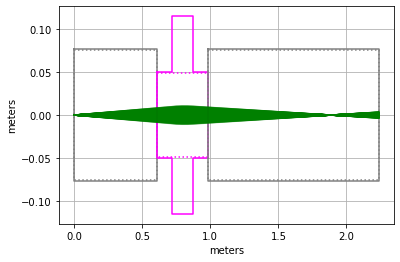

In [10]:
# # #trace and plot
# #
# #
# #
%matplotlib inline
swarm_initial_small=make_swarm(500,source_type='point')
swarm_traced_small=st.trace_swarm_through_lattice(swarm_initial_small,5e-6,1.0,parallel=True,use_fast_mode=False,accelerated=True,steps_per_logging=4)
lattice.show_lattice(swarm=swarm_traced_small,trace_line_alpha=.2,true_aspect_ratio=False,plot_outer=True,save_title='trace',dpi=300,show_markers=False)

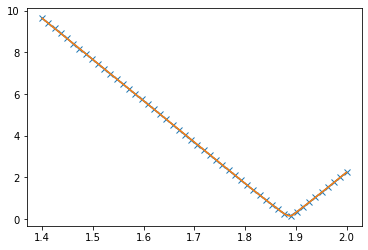

D90 min:  0.15  mm
D90 min location:  188.9  cm


In [11]:
from helperTools import make_dense_curve_1D_RBF
x_min,x_max=analyzer.end_drift_x_min_max()
x_vals=np.linspace(1.4,2.0,50)
d90_vals=[analyzer.D_90(x) for x in x_vals]
plt.plot(x_vals,d90_vals,marker='x')
x,y=make_dense_curve_1D_RBF(x_vals,d90_vals)
plt.plot(x,y)
plt.show()
d90_min=np.nanmin(y)
d90_x_focus=x[np.nanargmin(y)]
print("D90 min: ", round(d90_min,2) , ' mm')
print("D90 min location: ", round(1e2*d90_x_focus,1), ' cm')

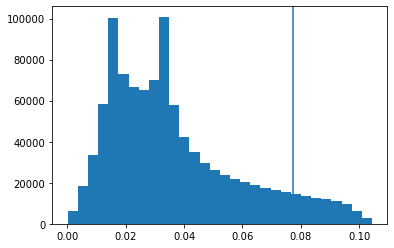

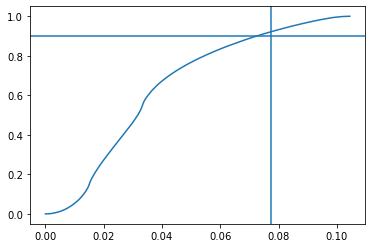

In [12]:
y_arr,z_arr=analyzer.interpolate(d90_x_focus)
r_arr=np.sqrt(y_arr**2+z_arr**2)
R_90=d90_min/2
plt.hist(r_arr,bins=30)
plt.axvline(R_90)
plt.show()
r_arr_sorted=np.sort(r_arr)
counts=np.ones(len(r_arr))
fraction=np.cumsum(counts)/sum(counts)
plt.plot(r_arr_sorted,fraction)
plt.axvline(R_90)
plt.axhline(.9)
plt.show()

In [17]:
r_max_fwhm=.0001
delta_r=r_max_fwhm/100
num_bins=round(r_max_fwhm/delta_r)
x_range=np.linspace(1.85,1.93,30)

def make_FWHM_profile():
    fwhm_vals=[analyzer.fwhm(x, r_max_fwhm, bins_center_sep_mm=delta_r) for x in x_range]
    # x,y=make_dense_curve_1D_RBF(x_range,fwhm_vals,smoothing=0)
    return x_range,fwhm_vals
def find_fwhm_min_and_location():
    x,y=make_FWHM_profile()
    fwhm_min=np.nanmin(y)
    fwhm_x_focus=x[np.nanargmin(y)]
    return fwhm_min,fwhm_x_focus

In [19]:
def show_and_get_fwhm_results():
    fwhm_min,fwhm_x_focus=find_fwhm_min_and_location()
    x,y=make_FWHM_profile()
    plt.plot(x,y)
    plt.show()
    print("FWHM min: ",round(fwhm_min ,2), ' mm')
    print("FWHM min location: ",round(1e2*fwhm_x_focus,1), ' cm')
    return fwhm_min,fwhm_x_focus
# fwhm_min,fwhm_x_focus=show_and_get_fwhm_results()
fwhm_x_focus=1.894

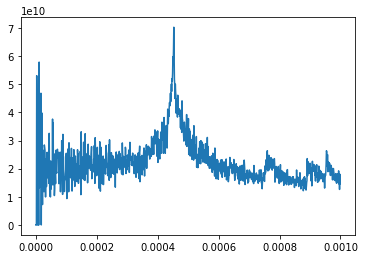

0.0019979999999999998

In [22]:
%matplotlib inline
x=fwhm_x_focus
bin_size=delta_r
r_cutoff=.001
r_vals,density=analyzer.transvers_position_density(x,r_cutoff,bin_size)
plt.plot(r_vals,density)
hwhm=fwhm_min/2
# plt.axhline(density.max()/2)
# plt.axvline(x=hwhm)
plt.show()
analyzer.fwhm(x,r_cutoff,bins_center_sep_mm=bin_size)

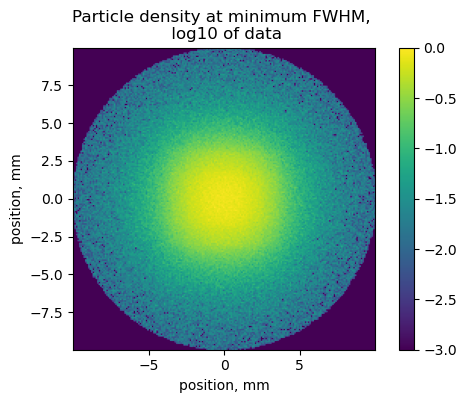

In [55]:
%matplotlib inline
x_interp=fwhm_x_focus
y_vals,z_vals=analyzer.interpolate(x_interp,max_radius_mm=10)
image,binx,biny=np.histogram2d(y_vals,z_vals,bins=200)
image=image/image.max()
image=np.log10(image+1e-3)
plt.figure(dpi=100)
plt.title("Particle density at minimum FWHM, \n log10 of data")
plt.imshow(image,extent=[binx.min(),binx.max(),biny.min(),biny.max()])
plt.xlabel("position, mm")
plt.ylabel("position, mm")
plt.colorbar()
plt.show()
# r_arr=np.sqrt(y_vals**2+z_vals**2)
# plt.hist(r_arr,bins=50)
# plt.show()

26701.0


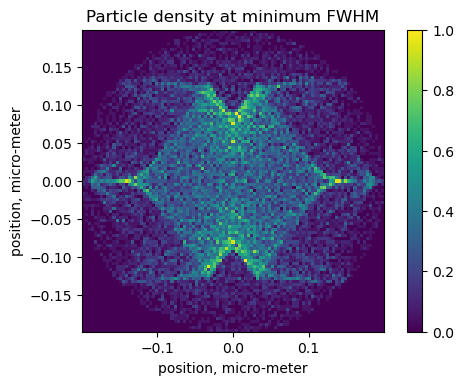

[-0.19888099541174156,
 0.19919663415192976,
 -0.19888099541174156,
 0.19919663415192976]

In [34]:
%matplotlib inline
x_interp=fwhm_x_focus+4e-4
r_max_fwhm=.0002
y_vals,z_vals=analyzer.interpolate(x_interp,max_radius_mm=r_max_fwhm)
num_bins=100
bins=np.linspace(y_vals.min(),y_vals.max(),num_bins)
image,binx,biny=np.histogram2d(y_vals,z_vals,bins=bins)
print(np.sum(image))
binx=binx*1e3
biny=biny*1e3
image=image/image.max()
image=np.rot90(image)
plt.figure(dpi=100)
plt.title("Particle density at minimum FWHM")
plt.imshow(image,extent=[binx.min(),binx.max(),biny.min(),biny.max()])
plt.xlabel("position, micro-meter")
plt.ylabel("position, micro-meter")
plt.colorbar()
plt.show()
# r_arr=np.sqrt(y_vals**2+z_vals**2)
# plt.hist(r_arr,bins=50)
# plt.show()
[binx.min(),binx.max(),biny.min(),biny.max()]

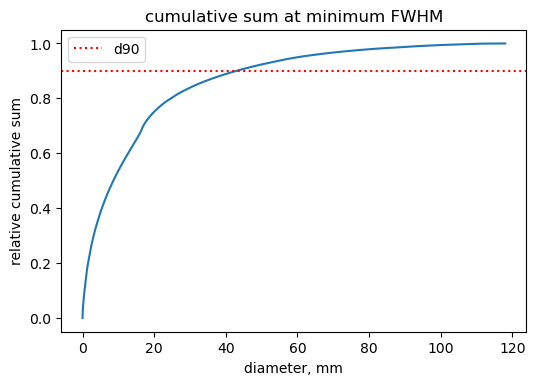

In [83]:
# cumulative particle distribution
%matplotlib inline
y_vals,z_vals=analyzer.interpolate(fwhm_x_focus)
r_vals=np.sort(np.sqrt(y_vals**2+z_vals**2))
diam_vals=2*r_vals
counts=np.ones(len(r_vals))
cum_sum=np.cumsum(counts)
cum_sum=cum_sum/cum_sum.max()

plt.figure(dpi=100)
plt.plot(diam_vals,cum_sum)
plt.title("cumulative sum at minimum FWHM")
plt.axhline(.9,label='d90',c='r',linestyle=':')
plt.xlabel("diameter, mm")
plt.ylabel("relative cumulative sum")
plt.legend()
plt.show()


In [43]:
print("D90 at min FWHM: "+ str(round(analyzer.D_90(fwhm_x_focus),2)) + ' mm')

D90 at min FWHM: 0.17 mm


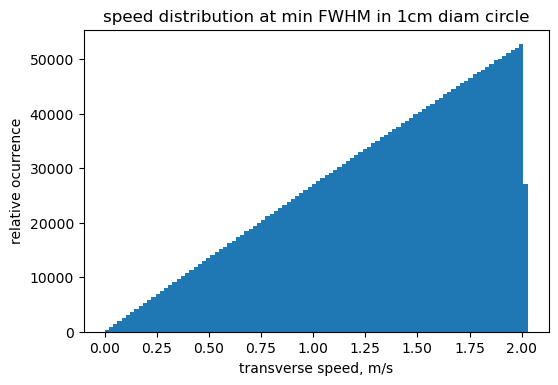

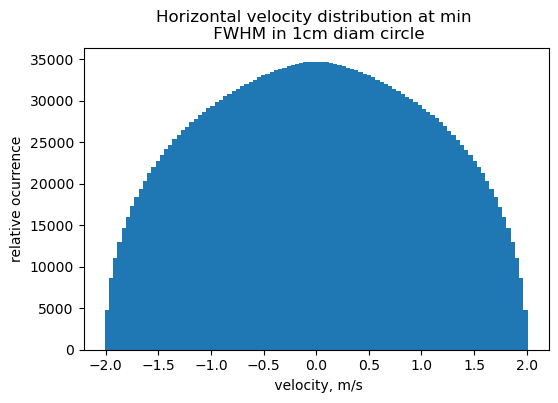

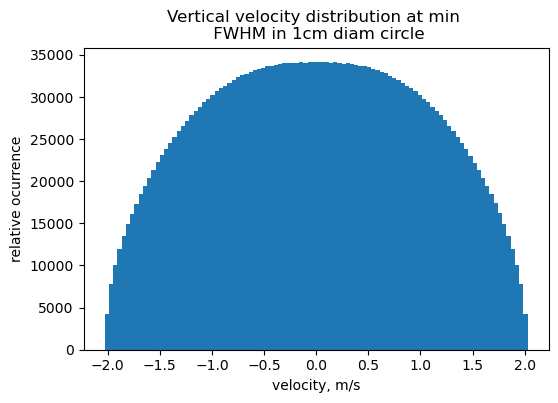

S90 is: 1.9 m/s


In [44]:
### velocity distribution in 1cm diam circle at min FWHM
r_ap_circle=5 #mm
y_vals,z_vals,p_vals=analyzer.interpolate(1.894, max_radius_mm=r_ap_circle,return_p=True)
px_vals,py_vals,pz_vals=p_vals.T
speed_trans=np.sqrt(py_vals**2+pz_vals**2)

plt.figure(dpi=100)
plt.title("speed distribution at min FWHM in 1cm diam circle")
plt.hist(speed_trans,bins=100)
plt.ylabel('relative ocurrence')
plt.xlabel("transverse speed, m/s")
plt.show()
plt.figure(dpi=100)
plt.title("Horizontal velocity distribution at min \n FWHM in 1cm diam circle")
plt.hist(py_vals,bins=100)
plt.ylabel('relative ocurrence')
plt.xlabel(" velocity, m/s")
plt.show()
plt.figure(dpi=100)
plt.title("Vertical velocity distribution at min \n FWHM in 1cm diam circle")
plt.hist(pz_vals,bins=100)
plt.xlabel("velocity, m/s")
plt.ylabel('relative ocurrence')
plt.show()

s90=np.sort(speed_trans)[round(len(speed_trans)*.9)]
print("S90 is: "+str(round(s90,1))+' m/s')

In [71]:
### survival at focus



percent of particles surviving to circle of diam 10 mm : 47


In [46]:
### focus s90

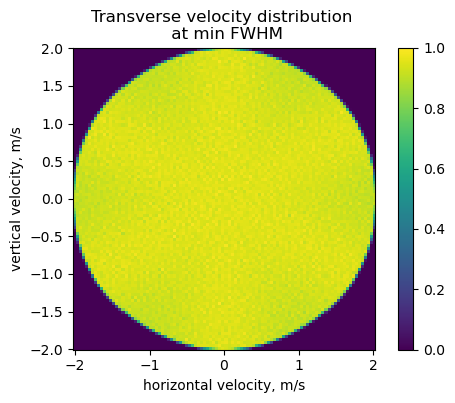

In [47]:
### 2D iamge of velocity distribution at focus
y_vals,z_vals=analyzer.interpolate(fwhm_x_focus, max_radius_mm=r_ap_circle)
full_ap_adjustment=(ap/.05)**2
frac_survival=full_ap_adjustment*len(y_vals)/num_particles
print('percent of particles surviving to circle of diam '+str(2*r_ap_circle)+ ' mm : '+str(round(1e2*frac_survival)))

image,binsy,binsz=np.histogram2d(py_vals,pz_vals,100)
image=image/np.max(image)
image=np.rot90(image)
binsy,binsz=binsz,binsy

plt.figure(dpi=100)
plt.title("Transverse velocity distribution \n at min FWHM")
plt.imshow(image,extent=[binsy.min(),binsy.max(),binsz.min(),binsz.max()],aspect=binsy.max()/binsz.max())

plt.xlabel("horizontal velocity, m/s")
plt.ylabel("vertical velocity, m/s")
plt.colorbar()

plt.show()

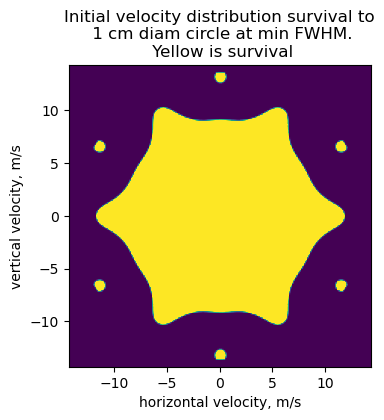

In [70]:
### distribution of survival into 1cm circle at x_fwhm from initial distirbution
_,_,p_vals,valid_indices=analyzer.interpolate(fwhm_x_focus, max_radius_mm=r_ap_circle,return_p=True,return_valid_indices=True)
py,pz=[],[]
weights=[0]*num_particles
for index in range(num_particles):
    p=swarm_traced.particles[index].pi
    py.append(p[1])
    pz.append(p[2])
for index in valid_indices:
    weights[index]=1
image,binsy,binsz=np.histogram2d(py,pz,200,weights=weights)
image=image/np.max(image)
image=np.rot90(image)
plt.figure(dpi=100)
plt.title("Initial velocity distribution survival to\n 1 cm diam circle at min FWHM.\n Yellow is survival")
plt.imshow(image,extent=[binsy.min(),binsy.max(),binsz.min(),binsz.max()],vmax=.5)
plt.xlabel("horizontal velocity, m/s")
plt.ylabel("vertical velocity, m/s")
# cbar.set_label('Survival')
plt.show()

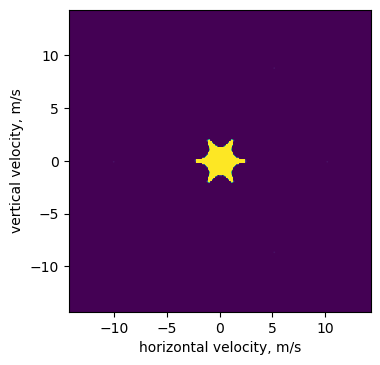

In [109]:
### survival into FWHM region from initial
%matplotlib inline
_,_,p_vals,valid_indices=analyzer.interpolate(fwhm_x_focus, max_radius_mm=.01,return_p=True,return_valid_indices=True)
py,pz=[],[]
weights=[0]*num_particles
for index in range(num_particles):
    p=swarm_traced.particles[index].pi
    py.append(p[1])
    pz.append(p[2])
for index in valid_indices:
    weights[index]=1
image,binsy,binsz=np.histogram2d(py,pz,200,weights=weights)
image=image/np.max(image)
image=np.rot90(image)
plt.figure(dpi=100)
# plt.title("Initial velocity distribution survival to\n 2 mm diam circle at min FWHM.\n Yellow is survival")
plt.imshow(image,extent=[binsy.min(),binsy.max(),binsz.min(),binsz.max()],vmax=.1)
plt.xlabel("horizontal velocity, m/s")
plt.ylabel("vertical velocity, m/s")
# cbar.set_label('Survival')
plt.show()

In [49]:
# # #trace and plot
# #
# #
# #
%matplotlib inline
swarm_traced_small=st.trace_swarm_through_lattice(goofy_swarm,5e-6,1.0,parallel=True,use_fast_mode=False,accelerated=True,steps_per_logging=4)
lattice.show_lattice(swarm=swarm_traced_small,trace_line_alpha=.2,true_aspect_ratio=False,plot_outer=True,save_title='trace',dpi=300,show_markers=False)

NameError: name 'goofy_swarm' is not defined